In [1]:
# import networkx as nx
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import random
import time

%matplotlib inline

In [2]:
# 网络数据导入为numpy数组
dataFile_1 = '../Matlab/data/BA_2000_3.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'])
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../Matlab/data/BA_2000_3_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'])
# network_information = nx.Graph(data['A'])

assert network_scale_1 == network_scale_2, "networks\' size don\'t match!"

In [3]:
# 参数设置

# 公共参数
Monte_Carlo_loop = 50    # 蒙特卡洛模拟次数
time_steps = 35    # 总时间步数
N = network_scale_1[0]    # 网络节点数

# p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入

# SIS参数
bata = 0.2    # 感染概率
mu = 0.1    # 恢复概率

Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])    # N行代表时间步数，T列代表节点数，记录每步所有节点的感染状态
# Nodes_SIS[0, p] = 1    # 第一步标出初始感染节点的位置

infective_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步感染节点数,用于最终统计
infective_count_average = np.zeros([1, time_steps])

# UAU参数
lamda = 0.4    # 传播率
delta = 0.15    # 遗忘率

Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的知情状态快照
# Nodes_UAU[0, p] = 1    # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

awareness_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
awareness_count_average = np.zeros([1, time_steps])

# 节点活跃度
activerate = 0.5
inactiverate = 0.5

Node_Active = np.ones([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的活跃状态快照
inactive_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
inactive_count_average = np.zeros([1, time_steps])

# 其他参数
aplha = 0    # 信息上传率
# aplha = 0.6    # 信息上传率
sigma_S = 0.7    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触

In [4]:
time_start = time.time()

for loop in range(Monte_Carlo_loop):

    p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入

    Nodes_SIS[loop, 0, p] = 1    # 第一步标出初始感染节点的位置
    Nodes_UAU[loop, 0, p] = 1    # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

    # 初始节点依概率变得不活跃
    p0 = np.random.rand(1)
    if p0 <= inactiverate:
        Node_Active[loop, 0, p] = 0    # 初始节点不活跃

    for t in range(time_steps-1):

        # UAU演化

        # 找到可以传播的活跃节点
        awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]    # 找到当前有传播力的节点的位置
        # awareness_count[loop] = len(active_node)    # 统计这一刻有传播力节点的数量

        # UAU传播过程
        for i in awareness_nodes:

#             spread_rate_current = lamda    # 这个暂时放这里，看能不能省掉
#             forget_rate_current = delta

            # UAU传播过程
            neighbor_total = np.where(network_information[i, :] == 1)[0]    # 找到第i个有传染力节点的邻居        
            neighbor_listener = np.setdiff1d(neighbor_total, awareness_nodes)    # 从neighbor_total去除awareness_nodes的节点，排除知情邻居

            # 让节点依次感染邻居(这种方式和SIS的的感染方式效果相同？)
            for j in neighbor_listener:
                p1 = np.random.rand(1)
                if p1 <= lamda:
                    Nodes_UAU[loop, t+1, j] = 1    # 这个节点已知

                    # 成功感染的节点下一时刻依概率变得不活跃
                    p3 = np.random.rand(1)
                    if p3 <= inactiverate:
                        Node_Active[loop, t+1, j] = 0    # 这个节点不活跃

            # UAU遗忘过程
            p2 = np.random.rand(1)
            if p2 <= delta:
                Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘

                # 节点依概率变得不活跃
                p4 = np.random.rand(1)
                if p4 <= inactiverate:
                    Node_Active[loop, t+1, i] = 1    # 这个节点重新活跃


        # SIS演化
        for i in range(N):

            # 0代表易感(S)，如果节点i健康且活跃，就查找其I状态的邻居（活跃节点处理方式不变）
            if ((Nodes_SIS[loop, t, i] == 0) and (Node_Active[loop, t, i] == 1)):

                neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 查找感染节点
                neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                Num_neighbor_infective = len(neighbor_infective)    # 统计

                infect_rate_current = bata    # 当前临时感染率
                rate_temp = 1    # 用于计算感染率

                # SIS感染率改变规则
                if Nodes_UAU[loop, t, i] == 0:
                    rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective                 

                elif Nodes_UAU[loop, t, i] == 1:
                    infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                    rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective


                # SIS感染过程
                v1 = 1 - rate_temp    # 这是最终计算的感染率？
                x1 = np.random.rand(1)
                if x1 <= v1:
                    Nodes_SIS[loop, t+1, i] = 1

                    # 感染节点信息上传(知晓)
                    x2 = np.random.rand(1)
                    if  x2 <= aplha:
                        Nodes_UAU[loop, t+1, i] = 1

            # 0代表易感(S)，如果节点i健康且不活跃，就查找其I状态的邻居
            elif ((Nodes_SIS[loop, t, i] == 0) and (Node_Active[loop, t, i] == 0)):

                neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居

                infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 感染节点
                active_nodes = np.where((Node_Active[loop, t, :] == 1))[0]    # 活跃节点

                neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                neighbor_infective_active = np.intersect1d(neighbor_infective, active_nodes)    # 取交集，真正可以感染它的活跃邻居

                Num_neighbor_infective_active = len(neighbor_infective_active)    # 统计

                infect_rate_current = bata    # 当前临时感染率
                rate_temp = 1    # 用于计算感染率

                # SIS感染率改变规则
                if Nodes_UAU[loop, t, i] == 0:
                    rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_active                 

                elif Nodes_UAU[loop, t, i] == 1:
                    infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                    rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_active


                # SIS感染过程
                v1 = 1 - rate_temp    # 这是最终计算的感染率？
                x1 = np.random.rand(1)
                if x1 <= v1:
                    Nodes_SIS[loop, t+1, i] = 1

                    # 感染节点信息上传(知晓)
                    x2 = np.random.rand(1)
                    if  x2 <= aplha:
                        Nodes_UAU[loop, t+1, i] = 1

            # SIS康复过程
            elif Nodes_SIS[loop, t, i] == 1:

                recover_rate_current = mu
                x3 = np.random.rand(1) 
                if x3 <= recover_rate_current:
                    Nodes_SIS[loop, t+1, i] = 0

            else:
                print("There is an else condition in SIS!")

    print("loop {} - time has passed: {} ".format(loop, time.time()-time_start))

loop 0 - time has passed: 3.5286030769348145 
loop 1 - time has passed: 7.153597354888916 
loop 2 - time has passed: 10.86469292640686 
loop 3 - time has passed: 14.379744529724121 
loop 4 - time has passed: 17.982078790664673 
loop 5 - time has passed: 21.613535404205322 
loop 6 - time has passed: 23.38883399963379 
loop 7 - time has passed: 26.984172821044922 
loop 8 - time has passed: 30.757080554962158 
loop 9 - time has passed: 34.44927358627319 
loop 10 - time has passed: 38.04558801651001 
loop 11 - time has passed: 41.461451053619385 
loop 12 - time has passed: 45.1236891746521 
loop 13 - time has passed: 48.713056802749634 
loop 14 - time has passed: 52.682485818862915 
loop 15 - time has passed: 56.44836902618408 
loop 16 - time has passed: 60.1654269695282 
loop 17 - time has passed: 63.8366482257843 
loop 18 - time has passed: 65.64481592178345 
loop 19 - time has passed: 69.49352192878723 
loop 20 - time has passed: 73.312264919281 
loop 21 - time has passed: 77.1111412048

In [5]:
datasave = './results/result.mat'
scio.savemat(datasave, {'NodeSIS':Nodes_SIS, 'NodeUAU':Nodes_UAU, 'Node_Active':Node_Active})

# print("Nodes_SIS: ", Nodes_SIS)
# print("Nodes_UAU: ", Nodes_UAU)

In [6]:
# 处理数据
for i in range(Monte_Carlo_loop):
    infective_count[i,:] = np.sum(Nodes_SIS[i,:,:], axis=1)
    awareness_count[i,:] = np.sum(Nodes_UAU[i,:,:], axis=1)
    inactive_count[i,:] = np.sum(1-Node_Active[i,:,:], axis=1)
    
infective_count_average = np.mean(infective_count, axis=0)
awareness_count_average = np.mean(awareness_count, axis=0)
inactive_count_average = np.mean(inactive_count, axis=0)

assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"
assert inactive_count_average.shape == (time_steps,), "inactive_count_average\'s size don\'t match!"

# print("infective_count_average: ", infective_count_average)
# print("awareness_count_average: ", awareness_count_average)

## 规模参照
# Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])
# infective_count = np.zeros([Monte_Carlo_loop, time_steps])
# infective_count_average = np.zeros([1, time_steps])

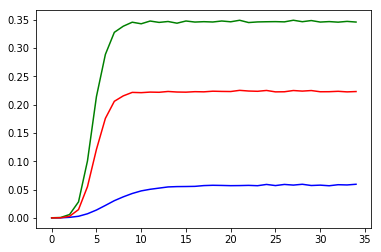

In [7]:
plt.plot(infective_count_average/N, color='blue', label='SIS')
plt.plot(awareness_count_average/N, color='green', label='UAU')
plt.plot(inactive_count_average/N, color='red', label='inactive')

In [ ]:
# 不活跃节点比例稳定以后始终比知情节点固定低一点

# 一种原因：接触层的信息上传会使得知情节点比正常演化多一点，并且来不及在当前时间更新为不活跃状态(已经证实)

In [ ]:
import time

print ("time.time(): %f " %time.time())

time_start=time.time()
time.sleep(1)
time_end=time.time()
print('totally cost',time_end-time_start)

In [ ]:
a = np.array([[1,2],[3,4],[5,6]])
datasave = './results/result.mat'
scio.savemat(datasave, {'A':a})
data_1 = scio.loadmat(datasave)